In [1]:
from geopandas.tools import sjoin_nearest
from scipy.spatial import cKDTree
from IPython.display import Image
import geopandas as gpd
from pyproj import CRS
import pandas as pd

from raster_functions import *
EPSG_Namibia_Code = 32733

/tmp/ipykernel_154137/899723803.py:1: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  from geopandas.tools import sjoin_nearest


In [2]:
%%time

directory = '/DATA/magalhaes/icesat2_atl03/atl03_hdf_window/'

file_pattern = ['ATL03_TOC']
start_date = '2018-10-01'
nmonths = 41

dfs_list = merge_df_nmonths(directory, start_date, nmonths, file_pattern)

CPU times: user 18.2 s, sys: 4.48 s, total: 22.7 s
Wall time: 1min 17s


In [3]:
%%time

gdf_TOC = convert_to_geodataframe(dfs_list)

del dfs_list

CPU times: user 1min 23s, sys: 837 ms, total: 1min 24s
Wall time: 1min 24s


In [4]:
gdf_TOC = gdf_TOC[0]

In [5]:
gdf_TOC.head()

,Latitude,Longitude,Along-track_Distance,Land,Easting,Northing,crosstrack,alongtrack,Ground_interp_Height,TOC_Height,z,x,NN,Photons_Numb,Date,easting_sq,northing_sq,geometry
142499,-17.000671,15.857191,18.986261,3.0,591244.693723,8.120171e+06,2305.953343,1.105844e+06,1134.976388,5.400565,0.136896,0.000116,6.0,1.0,2018-10-14,591,8120,POINT (591244.694 8120171.145)
142537,-17.001241,15.857133,2.277661,3.0,591238.229173,8.120108e+06,2305.939123,1.105908e+06,1135.931099,3.448173,0.025532,0.000306,6.0,1.0,2018-10-14,591,8120,POINT (591238.229 8120108.106)
142690,-17.003427,15.856904,5.070394,4.0,591212.839498,8.119866e+06,2306.487010,1.106151e+06,1135.742902,5.294452,0.130843,0.001035,7.0,2.0,2018-10-14,591,8119,POINT (591212.839 8119866.425)
142729,-17.003971,15.856849,5.487452,4.0,591206.676458,8.119806e+06,2306.467529,1.106211e+06,1135.869562,5.552801,0.145579,0.001216,6.0,2.0,2018-10-14,591,8119,POINT (591206.676 8119806.268)
143024,-17.009367,15.856291,4.938826,4.0,591144.712249,8.119209e+06,2307.093007,1.106811e+06,1134.299569,3.344474,0.019617,0.003015,7.0,1.0,2018-10-14,591,8119,POINT (591144.712 8119209.477)


In [6]:
%%time

area_paths = ['../catchment_areas/areas/savanna2.geojson']

clipped_gdfs = []
for path in area_paths:
    clip_gdf = gpd.read_file(path)
    clip_gdf = clip_gdf.to_crs(epsg=EPSG_Namibia_Code)
    gdf_TOC.loc[gdf_TOC.intersects(clip_gdf.unary_union), 'clipped'] = True
    clipped_gdf = gdf_TOC[gdf_TOC['clipped'] == True].copy()
    clipped_gdfs.append(clipped_gdf)
    gdf_TOC.drop('clipped', axis=1, inplace=True)

no_catchment_TOC = clipped_gdfs[0]

CPU times: user 1h 9min 51s, sys: 982 ms, total: 1h 9min 52s
Wall time: 1h 9min 52s


In [7]:
no_catchment_TOC.head()

,Latitude,Longitude,Along-track_Distance,Land,Easting,Northing,crosstrack,alongtrack,Ground_interp_Height,TOC_Height,z,x,NN,Photons_Numb,Date,easting_sq,northing_sq,geometry,clipped
142690,-17.003427,15.856904,5.070394,4.0,591212.839498,8.119866e+06,2306.487010,1.106151e+06,1135.742902,5.294452,0.130843,0.001035,7.0,2.0,2018-10-14,591,8119,POINT (591212.839 8119866.425),True
142729,-17.003971,15.856849,5.487452,4.0,591206.676458,8.119806e+06,2306.467529,1.106211e+06,1135.869562,5.552801,0.145579,0.001216,6.0,2.0,2018-10-14,591,8119,POINT (591206.676 8119806.268),True
143024,-17.009367,15.856291,4.938826,4.0,591144.712249,8.119209e+06,2307.093007,1.106811e+06,1134.299569,3.344474,0.019617,0.003015,7.0,1.0,2018-10-14,591,8119,POINT (591144.712 8119209.477),True
143042,-17.009597,15.856267,10.472569,3.0,591142.000449,8.119184e+06,2307.193157,1.106837e+06,1134.251844,4.791369,0.102148,0.003092,9.0,1.0,2018-10-14,591,8119,POINT (591142.000 8119184.071),True
143298,-17.013623,15.855849,17.775431,3.0,591095.604103,8.118739e+06,2307.821173,1.107284e+06,1132.781609,6.067512,0.174938,0.004435,6.0,1.0,2018-10-14,591,8118,POINT (591095.604 8118738.780),True


In [8]:
no_catchment_TOC.shape, gdf_TOC.shape

((6044449, 19), (18189581, 18))

In [9]:
no_catchment_TOC.to_file('../catchment_areas/areas/no_catchment_TOC2.gpkg', driver='GPKG', layer='points')

In [12]:
del gdf_TOC, no_catchment_TOC

In [2]:
%%time

directory = '/DATA/magalhaes/icesat2_atl03/atl03_hdf_window/'

file_pattern = ['ATL03_Grass']
start_date = '2018-10-01'
nmonths = 41

dfs_list = merge_df_nmonths(directory, start_date, nmonths, file_pattern)

CPU times: user 10.6 s, sys: 2.62 s, total: 13.2 s
Wall time: 15.4 s


In [3]:
%%time

gdf_Grass = convert_to_geodataframe(dfs_list)

del dfs_list

CPU times: user 1min 19s, sys: 733 ms, total: 1min 19s
Wall time: 1min 19s


In [4]:
gdf_Grass = gdf_Grass[0]
gdf_Grass.head()

,Latitude,Longitude,Along-track_Distance,Land,Easting,Northing,crosstrack,alongtrack,Ground_interp_Height,Grass_Height,z,x,NN,Date,easting_sq,northing_sq,geometry
142831,-17.006168,15.856624,9.563341,4.0,591181.663315,8.119563e+06,2306.505033,1.106455e+06,1135.218863,0.540293,0.016118,0.002004,7.0,2018-10-14,591,8119,POINT (591181.663 8119563.258)
142878,-17.006975,15.856539,19.189495,4.0,591172.233553,8.119474e+06,2306.765878,1.106545e+06,1135.705776,0.530674,0.012268,0.002273,6.0,2018-10-14,591,8119,POINT (591172.234 8119474.058)
143061,-17.009942,15.856231,8.770649,4.0,591137.999919,8.119146e+06,2307.274841,1.106875e+06,1133.683584,0.552745,0.021100,0.003262,7.0,2018-10-14,591,8119,POINT (591138.000 8119145.945)
143329,-17.014134,15.855798,14.432148,4.0,591089.891810,8.118682e+06,2307.734896,1.107341e+06,1132.605453,0.533463,0.013385,0.004659,8.0,2018-10-14,591,8118,POINT (591089.892 8118682.355)
143468,-17.016108,15.855594,13.703811,4.0,591067.223404,8.118464e+06,2307.966356,1.107561e+06,1133.939130,0.530719,0.012286,0.005317,8.0,2018-10-14,591,8118,POINT (591067.223 8118464.057)


In [5]:
gdf_Grass.shape

(16924957, 17)

**Clip areas drained by no-catchment rivers:**

In [6]:
%%time

area_paths = ['../catchment_areas/areas/savanna2.geojson']

clipped_gdfs = []
for path in area_paths:
    clip_gdf = gpd.read_file(path)
    clip_gdf = clip_gdf.to_crs(epsg=EPSG_Namibia_Code)
    gdf_Grass.loc[gdf_Grass.intersects(clip_gdf.unary_union), 'clipped'] = True
    clipped_gdf = gdf_Grass[gdf_Grass['clipped'] == True].copy()
    clipped_gdfs.append(clipped_gdf)
    gdf_Grass.drop('clipped', axis=1, inplace=True)

no_catchment_Grass = clipped_gdfs[0]

CPU times: user 54min 56s, sys: 443 ms, total: 54min 57s
Wall time: 54min 57s


In [7]:
no_catchment_Grass.head()

,Latitude,Longitude,Along-track_Distance,Land,Easting,Northing,crosstrack,alongtrack,Ground_interp_Height,Grass_Height,z,x,NN,Date,easting_sq,northing_sq,geometry,clipped
142831,-17.006168,15.856624,9.563341,4.0,591181.663315,8.119563e+06,2306.505033,1.106455e+06,1135.218863,0.540293,0.016118,0.002004,7.0,2018-10-14,591,8119,POINT (591181.663 8119563.258),True
142878,-17.006975,15.856539,19.189495,4.0,591172.233553,8.119474e+06,2306.765878,1.106545e+06,1135.705776,0.530674,0.012268,0.002273,6.0,2018-10-14,591,8119,POINT (591172.234 8119474.058),True
143061,-17.009942,15.856231,8.770649,4.0,591137.999919,8.119146e+06,2307.274841,1.106875e+06,1133.683584,0.552745,0.021100,0.003262,7.0,2018-10-14,591,8119,POINT (591138.000 8119145.945),True
143329,-17.014134,15.855798,14.432148,4.0,591089.891810,8.118682e+06,2307.734896,1.107341e+06,1132.605453,0.533463,0.013385,0.004659,8.0,2018-10-14,591,8118,POINT (591089.892 8118682.355),True
143468,-17.016108,15.855594,13.703811,4.0,591067.223404,8.118464e+06,2307.966356,1.107561e+06,1133.939130,0.530719,0.012286,0.005317,8.0,2018-10-14,591,8118,POINT (591067.223 8118464.057),True


In [8]:
no_catchment_Grass.shape, gdf_Grass.shape

((4006335, 18), (16924957, 17))

In [9]:
no_catchment_Grass.to_file('../catchment_areas/areas/no_catchment_Grass2.gpkg', driver='GPKG', layer='points')

In [ ]:
del gdf_Grass, clip_gdf, clipped_gdfs

In [1]:
import dask_geopandas as dask_gpd

# Define the file path
filepath = '../catchment_areas/areas/no_catchment_TOC1.gpkg'

# Load the file as a Dask GeoDataFrame
TOC = dask_gpd.read_file(filepath, chunksize=100000000)

# Compute the Dask GeoDataFrame into a GeoDataFrame
no_catchment_TOC = TOC.compute()

/opt/miniconda/envs/icesat2/lib/python3.11/site-packages/dask_geopandas/backends.py:13: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas


In [2]:
import dask_geopandas as dask_gpd

# Define the file path
filepath = '../catchment_areas/areas/no_catchment_TOC_combined.gpkg'

# Load the file as a Dask GeoDataFrame
TOC = dask_gpd.read_file(filepath, chunksize=1000000000)

# Compute the Dask GeoDataFrame into a GeoDataFrame
no_catchment_TOC = TOC.compute()

In [3]:
no_catchment_TOC.shape

(14354980, 19)

In [4]:
import dask_geopandas as dask_gpd

# Define the file path
filepath = '../catchment_areas/areas/no_catchment_Grass_combined.gpkg'

# Load the file as a Dask GeoDataFrame
Grass = dask_gpd.read_file(filepath, chunksize=1000000000)

# Compute the Dask GeoDataFrame into a GeoDataFrame
no_catchment_Grass = Grass.compute()

In [ ]:
import dask_geopandas as dask_gpd

# Define the file path
filepath = '../catchment_areas/areas/no_catchment_Grass2.gpkg'

# Load the file as a Dask GeoDataFrame
Grass = dask_gpd.read_file(filepath, chunksize=100000000)

# Compute the Dask GeoDataFrame into a GeoDataFrame
no_catchment_Grass2 = Grass.compute()

In [ ]:
no_catchment_Grass.shape, no_catchment_Grass2.shape

In [ ]:
no_catchment_Grass2 = Grass.compute()

In [5]:
import dask.dataframe as dd

# Assuming dgdf1 and dgdf2 are your Dask-GeoPandas GeoDataFrames
no_catchment_Grass = dd.concat([no_catchment_Grass, no_catchment_Grass2])


In [3]:
import dask.dataframe as dd

# Assuming dgdf1 and dgdf2 are your Dask-GeoPandas GeoDataFrames
no_catchment_TOC = dd.concat([no_catchment_TOC, no_catchment_TOC2])


In [6]:
no_catchment_Grass.head()

,Latitude,Longitude,Along-track_Distance,Land,Easting,Northing,crosstrack,alongtrack,Ground_interp_Height,Grass_Height,z,x,NN,Date,easting_sq,northing_sq,clipped,geometry
0,-18.246186,15.728143,7.299638,4.0,576977.105253,7.982424e+06,2415.925265,1.244328e+06,1109.692208,0.517386,0.006951,0.415382,8.0,2018-10-14,576,7982,1,POINT (576977.105 7982423.866)
1,-18.248450,15.727904,18.807655,4.0,576950.906134,7.982174e+06,2416.395109,1.244580e+06,1109.480589,0.538210,0.015284,0.416136,9.0,2018-10-14,576,7982,1,POINT (576950.906 7982173.545)
2,-18.257030,15.727016,12.109447,4.0,576853.241841,7.981225e+06,2416.522485,1.245534e+06,1108.823196,0.618210,0.047298,0.418997,7.0,2018-10-14,576,7981,1,POINT (576853.242 7981224.523)
3,-18.257043,15.727015,13.528602,4.0,576853.100623,7.981223e+06,2416.518625,1.245536e+06,1108.788099,0.564440,0.025781,0.419001,8.0,2018-10-14,576,7981,1,POINT (576853.101 7981223.111)
4,-18.257891,15.726928,7.719688,4.0,576843.562114,7.981129e+06,2416.418854,1.245630e+06,1109.351936,0.605217,0.042099,0.419284,6.0,2018-10-14,576,7981,1,POINT (576843.562 7981129.326)


In [7]:
import geopandas as gpd

# Assuming dgdf is your Dask-GeoPandas GeoDataFrame
no_catchment_Grass = no_catchment_Grass.compute()


In [4]:
import geopandas as gpd

# Assuming dgdf is your Dask-GeoPandas GeoDataFrame
no_catchment_TOC = no_catchment_TOC.compute()


In [5]:
no_catchment_TOC.to_file('../catchment_areas/areas/no_catchment_TOC_combined.gpkg', driver='GPKG', layer='points')

In [8]:
no_catchment_Grass.to_file('../catchment_areas/areas/no_catchment_Grass_combined.gpkg', driver='GPKG', layer='points')

In [2]:
import dask_geopandas as dask_gpd

toc_file = '../catchment_areas/areas/no_catchment_TOC_combined.gpkg'
no_catchment_TOC = dask_gpd.read_file(toc_file, layer='points', chunksize=100000)

grass_file = '../catchment_areas/areas/no_catchment_Grass.gpkg'
no_catchment_Grass = dask_gpd.read_file(grass_file, layer='points', chunksize=100000)

In [3]:
# convert the Dask GeoDataFrame to a Pandas DataFrame
no_catchment_TOC = no_catchment_TOC.compute()
no_catchment_Grass = no_catchment_Grass.compute()

In [4]:
# Reset index to use Dates
no_catchment_TOC = no_catchment_TOC.set_index('Date')
no_catchment_Grass = no_catchment_Grass.set_index('Date')

In [5]:
# Calculate median values for each month
no_catchment_TOC_median = no_catchment_TOC.groupby(no_catchment_TOC.index.strftime('%Y-%m'))['TOC_Height'].median().reset_index()
no_catchment_Grass_median = no_catchment_Grass.groupby(no_catchment_Grass.index.strftime('%Y-%m'))['Grass_Height'].median().reset_index()
no_catchment_Grass_median = no_catchment_Grass_median.set_index('Date')
no_catchment_TOC_median = no_catchment_TOC_median.set_index('Date')

#### Boxplot of areas withing no_catchment rivers catchment areas

In [6]:
from matplotlib.ticker import MaxNLocator
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import seaborn as sns
import ee

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# ee.Authenticate()

Enter verification code: 4/1AbUR2VNZpobVO400yrF83nIijcd7eBaEdF4ki1KoJYpy4kajV7GDZoY_Ey0

Successfully saved authorization token.


In [7]:
ee.Initialize()
print(ee.__version__)

0.1.337


In [8]:
# define region of interest
minx, maxx = 14, 17
miny, maxy = -20, -17
aoi = Polygon([[minx, maxy], [maxx, maxy], [maxx, miny], [minx, miny]])
ROI = gee_geometry_from_shapely(aoi)
# define period of time series analysis
start_date = '2018-10-01'
end_date = '2022-03-30'

/DATA/magalhaes/ICESat-2_SVDA/JupyterNotebooks/catchment_areas/raster_functions.py:115: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  ty = geom.type


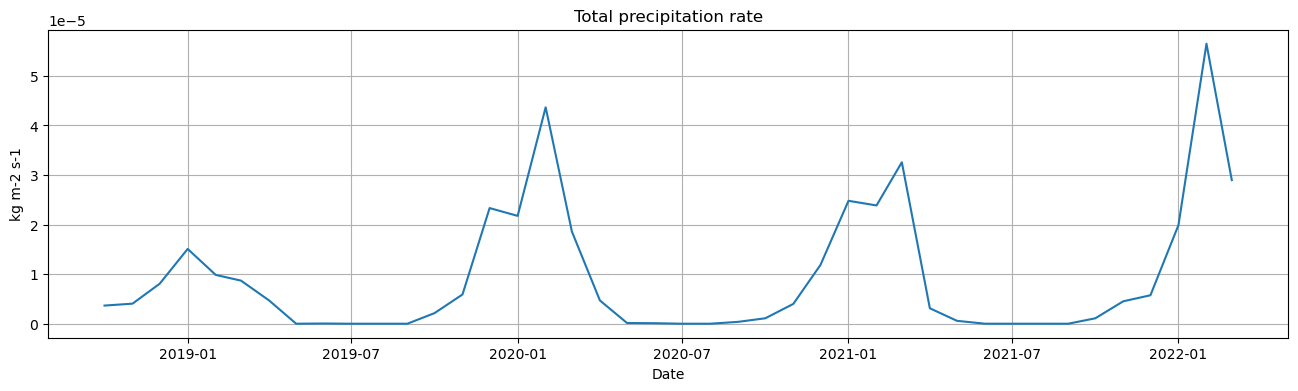

In [9]:
def createTS(image):
    date = image.get('system:time_start')
    value = image.reduceRegion(reducer=ee.Reducer.mean(), geometry=ROI).get(var)
    std = image.reduceRegion(reducer=ee.Reducer.stdDev(), geometry=ROI).get(var)
    ft = ee.Feature(None, {'date': ee.Date(date).format('Y/M/d'), var: value, 'STD': std})
    return ft

def TS_to_pandas(TS):
    dump = TS.getInfo()
    fts = dump['features']
    out_vals = np.empty((len(fts)))
    out_dates = []
    out_std = np.empty((len(fts)))
    
    for i, f in enumerate(fts):
        props = f['properties']
        date = props['date']
        val = props[var]
        std = props['STD']
        out_vals[i] = val
        out_std[i] = std
        out_dates.append(pd.Timestamp(date))
    
    ser = pd.Series(out_vals, index=out_dates)
    return ser, out_std

# Source of precipitation and soil moisture data
# https://developers.google.com/earth-engine/datasets/catalog/NASA_FLDAS_NOAH01_C_GL_M_V001#description

Precip = ee.ImageCollection('NASA/FLDAS/NOAH01/C/GL/M/V001').filter(ee.Filter.date(start_date, end_date)).select('Rainf_f_tavg').filterBounds(ROI)     
var = 'Rainf_f_tavg'
TS = Precip.map(createTS)
Precip_ts, Precip_std = TS_to_pandas(TS)
precipitation = Precip_ts.groupby(Precip_ts.index.date).median()

precipitation.plot(figsize=(16,4))
plt.title('Total precipitation rate')
plt.xlabel('Date')
plt.ylabel('kg m-2 s-1')
plt.grid()

In [ ]:
palette = 'Spectral'
sns.set(style='white')

fig, axs = plt.subplots(2,1, figsize=(20, 12), gridspec_kw={'height_ratios': [8, 6]})
plt.subplots_adjust(hspace=0.3)

for ax in axs:
    for spine in ["top", "right", "bottom", "left"]:
        ax.spines[spine].set_visible(False)

norm = plt.Normalize(precipitation.min(), precipitation.max())
colors = plt.cm.Spectral(norm(precipitation))

sns.lineplot(data=no_catchment_TOC_median, x='Date', y='TOC_Height', ax=axs[0], linestyle='--',color='r', label='median')
sns.boxplot(x = no_catchment_TOC.index.strftime('%Y-%m'),
            y = no_catchment_TOC['TOC_Height'],
            palette = colors,
            ax=axs[0], width=0.4)

axs[0].set_xlabel('', fontsize=14)
axs[0].set_ylabel('TOC Height [m]', fontsize=14)
axs[0].tick_params(axis='both', which='major', labelsize=12)
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=30)

sns.lineplot(data=no_catchment_Grass_median, x='Date', y='Grass_Height', ax=axs[1], linestyle='--',color='r', label='median')
sns.boxplot(x = no_catchment_Grass.index.strftime('%Y-%m'),
            y = no_catchment_Grass['Grass_Height'],
            palette = colors,
            ax=axs[1], width=0.4)

axs[1].set_ylabel('Grass Height [m]', fontsize=14)
axs[1].set_xlabel('Time [%Y-%m]', fontsize=14)
axs[1].tick_params(axis='both', which='major', labelsize=12)
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=30)
axs[1].yaxis.set_major_locator(MaxNLocator(integer=True))

sm = plt.cm.ScalarMappable(cmap=palette, norm=plt.Normalize(vmin=precipitation.min(), vmax=precipitation.max()))
sm.set_array([])

cbar = plt.colorbar(sm, ax=axs.ravel().tolist(), orientation='horizontal', pad=0.1)
cbar.ax.set_xlabel('Normalized total precipitation rate values', fontsize=14)
cbar.ax.tick_params(axis='both', which='major', labelsize=14)

In [12]:
def process_dataframes(dataframes, start_value, end_value, start_value_, end_value_):
    subset_dfs = []
    for df in dataframes:
        # select the rows of the DataFrame where the values in 'col' are within the current pair of values
        df_subset = df[(df['easting_sq'] >= start_value) & (df['easting_sq'] < end_value)]
        df_subset = df_subset[(df_subset['northing_sq'] >= start_value_) & (df_subset['northing_sq'] < end_value_)]
        df_subset = df_subset.loc[:, ~df_subset.columns.duplicated(keep='first')]
        subset_dfs.append(df_subset)

    return subset_dfs

In [20]:
# Reset index to use Dates
no_catchment_TOC = no_catchment_TOC.reset_index()
no_catchment_Grass = no_catchment_Grass.reset_index()

In [ ]:
window_size = 1

# Find the minimum and maximum values of easting_sq and northing_sq
min_easting_sq = no_catchment_TOC['easting_sq'].min()
max_easting_sq = no_catchment_TOC['easting_sq'].max()
min_northing_sq = no_catchment_TOC['northing_sq'].min()
max_northing_sq = no_catchment_TOC['northing_sq'].max()

east = list(range(int(min_easting_sq), int(max_easting_sq+1), window_size))
north = list(range(min_northing_sq, max_northing_sq+1, window_size))

for e in range(len(east)-1):
    for n in range(len(north)-1):

        # extract the current pair of values from the list
        start_value = east[e]
        end_value = east[e+1]
        start_value_ = north[n]
        end_value_ = north[n+1]

        dataframes = [no_catchment_Grass, no_catchment_TOC]
        df_Grass, df_TOC = process_dataframes(dataframes,
                                              start_value,
                                              end_value, 
                                              start_value_, 
                                              end_value_)
        

        df_TOC_index = df_TOC.set_index('Date')
        df_Grass_index = df_Grass.set_index('Date')

        df_TOC_median = df_TOC_index.groupby(df_TOC_index.index.strftime('%Y-%m-%d'))['TOC_Height'].median().reset_index()
        df_Grass_median = df_Grass_index.groupby(df_Grass_index.index.strftime('%Y-%m-%d'))['Grass_Height'].median().reset_index()

        df_Grass_median = df_Grass_median.set_index('Date')
        df_TOC_median = df_TOC_median.set_index('Date')

        if len(df_TOC_index.index.unique()) >= 5:
            sns.set(style='darkgrid')
            palette = 'Spectral'

            fig, axs = plt.subplots(2,1, figsize=(20, 7), gridspec_kw={'height_ratios': [6, 4]}, sharex=True)

            norm = plt.Normalize(precipitation.min(), precipitation.max())
            colors = plt.cm.Spectral(norm(precipitation))
            sns.lineplot(data=df_TOC_median, x='Date', y='TOC_Height', ax=axs[0], linestyle='--',color='r', label='median')
            sns.boxplot(x = df_TOC_index.index.strftime('%Y-%m-%d'),
                        y = df_TOC_index['TOC_Height'],
                        palette = colors,
                        ax=axs[0], width=0.05)

            axs[0].set_xlabel('', fontsize=10)
            axs[0].set_ylabel('TOC Height [m]', fontsize=10)
            axs[0].tick_params(axis='both', which='major', labelsize=10)
            axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=30)
            axs[0].legend(loc='upper right')

            sns.lineplot(data=df_Grass_median, x='Date', y='Grass_Height', ax=axs[1], linestyle='--',color='r')
            sns.boxplot(x = df_Grass_index.index.strftime('%Y-%m-%d'),
                        y = df_Grass_index['Grass_Height'],
                        ax=axs[1], width=0.05, palette = colors)

            axs[1].set_ylabel('Grass Height [m]', fontsize=10)
            axs[1].set_xlabel('Time [%Y-%m-%d]', fontsize=10)
            axs[1].tick_params(axis='both', which='major', labelsize=10)
            axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=30)
            axs[1].yaxis.set_major_locator(MaxNLocator(integer=True))

            # create a new axis for the colorbar
            cbar_ax = fig.add_axes([1.03, 0.15, 0.01, 0.7]) # [left, bottom, width, height]

            # create the colorbar
            sm = plt.cm.ScalarMappable(cmap=palette, norm=plt.Normalize(vmin=precipitation.min(), vmax=precipitation.max()))
            sm.set_array([])
            cbar = plt.colorbar(sm, cax=cbar_ax)

            # adjust the colorbar's tick labels and title
            cbar.ax.tick_params(labelsize=10)
            cbar.ax.set_title('Normalized Precipitation', fontsize=10)
            
            fig.subplots_adjust(hspace=0.1) # increase the vertical spacing between the subplots
            fig.suptitle(f'Top of Canopy Height and Grass Height from: {start_date} to 2022-03-30. Easting: {start_value}000-{end_value}000, Northing: {start_value_}000-{end_value_}000', fontsize=14)
            fig.tight_layout()
            plt.show()

In [24]:
stats_TOC = no_catchment_TOC[['TOC_Height']].describe().round(2)
stats_Grass = no_catchment_Grass[['Grass_Height']].describe().round(2)

In [25]:
# Combine statistics into a single table
table = pd.concat([stats_TOC, stats_Grass], axis=1)
table.columns = ['TOC Height', 'Grass Height']

# Convert table to LaTeX format
latex_table = table.to_latex()

# Print LaTeX code
print(latex_table)

\begin{tabular}{lrr}
\toprule
{} &   TOC Height &  Grass Height \\
\midrule
count &  14354980.00 &   13486273.00 \\
mean  &        11.05 &          1.71 \\
std   &         5.63 &          0.77 \\
min   &         3.00 &          0.50 \\
25\%   &         5.87 &          1.00 \\
50\%   &        10.74 &          1.70 \\
75\%   &        15.37 &          2.42 \\
max   &        84.79 &          3.00 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_136941/1810177288.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = table.to_latex()


---